# Analysis 3

Now that out data is properly cleaned, we can perform the analysis without having all those table outputs trying to get it in the shape we want. 
***

In [173]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Load the CSV file
oc_df = pd.read_csv('output_cleaned_combined.csv')

# Display basic information about the dataset
# print(ihs_df.info())

## Question 1
#### Does individual performance have a significant outcome on match victory? 

How do we measure this? 

#### *Performance Score* 
- Compare individual performance to average KDA, dmg, heal, etc. value for all roles. 
- Is it slightly above? A standard deviation? 

In [174]:
# Group by role and calculate the mean for kills, deaths, and assists
role_stats = oc_df.groupby('role')[['kills_x', 'deaths_x', 'assists_x', 'hero_damage', 'hero_healed', 'damage_taken']].mean()

# Calculate the overall standard deviation for kills, deaths, and assists
overall_std = oc_df[['kills_x', 'deaths_x', 'assists_x', 'hero_damage', 'hero_healed', 'damage_taken']].std()

print("Average values by role:")
print(role_stats)
print("\nOverall standard deviation:")
print(overall_std)

Average values by role:
              kills_x  deaths_x  assists_x   hero_damage   hero_healed  \
role                                                                     
DUELIST     13.669248  4.502212   1.723451  12725.507560    628.124943   
STRATEGIST   8.914005  4.170762  14.683047   6004.337263  16497.253780   
VANGUARD    12.547703  4.019435   1.296820  12314.789154    721.716324   

            damage_taken  
role                      
DUELIST      7839.215696  
STRATEGIST   7393.675143  
VANGUARD    24216.188741  

Overall standard deviation:
kills_x             9.364819
deaths_x            3.252969
assists_x           9.587514
hero_damage      6858.112447
hero_healed      9869.446408
damage_taken    10393.058701
dtype: float64


C:\Users\jcing\AppData\Local\Temp\ipykernel_46920\1899089149.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_stats['performance_score'] = merged_stats.groupby('player_uid').apply(


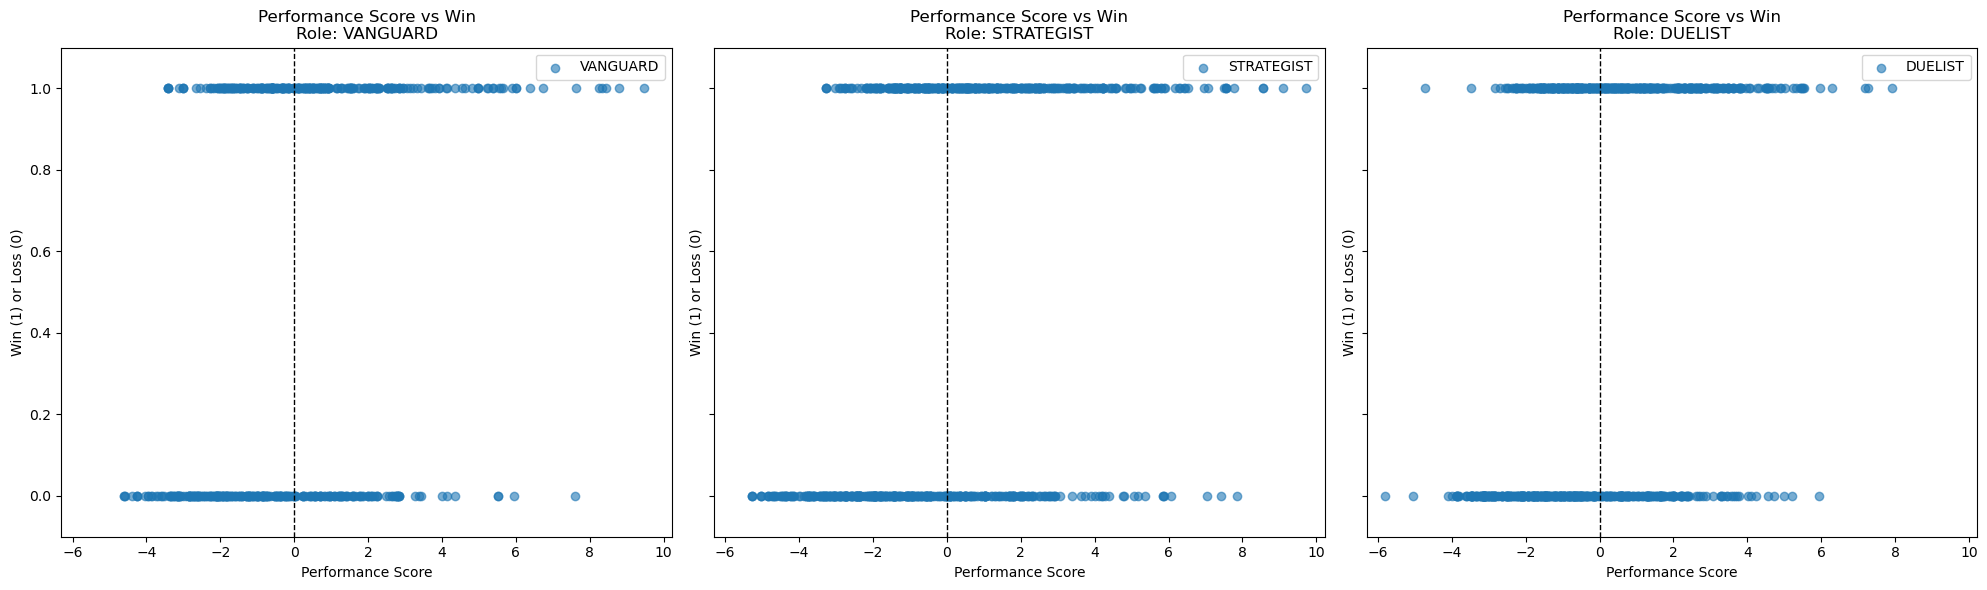

In [175]:
# Merge individual stats with role stats to compare individual performance to role averages
merged_stats = oc_df.merge(role_stats, on='role', suffixes=('', '_avg'))

# Calculate performance score (z_score) for each unique player based on their deviation from the role averages
merged_stats['performance_score'] = merged_stats.groupby('player_uid').apply(
    lambda group: (
        (group['kills_x'] - group['kills_x_avg']) / overall_std['kills_x'] +
        (group['deaths_x_avg'] - group['deaths_x']) / overall_std['deaths_x'] +
        (group['assists_x'] - group['assists_x_avg']) / overall_std['assists_x'] +
        (group['hero_damage'] - group['hero_damage_avg']) / overall_std['hero_damage'] +
        (group['hero_healed'] - group['hero_healed_avg']) / overall_std['hero_healed'] +
        (group['damage_taken'] - group['damage_taken_avg']) / overall_std['damage_taken']
    )
).reset_index(level=0, drop=True)

# Select relevant columns for the new dataframe
performance_df = merged_stats[['player_uid', 'match_uid', 'role', 'performance_score', 'is_win']]

# Create a figure with 3 subplots for each role
roles = performance_df['role'].unique()
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Determine the range for the axes
x_min = performance_df['performance_score'].min()-0.5
x_max = performance_df['performance_score'].max()+0.5
y_min = performance_df['is_win'].min()-0.1
y_max = performance_df['is_win'].max() +0.1

# Iterate through each role and plot in a separate subplot
for ax, role in zip(axes, roles):
    role_data = performance_df[performance_df['role'] == role]
    ax.scatter(role_data['performance_score'], role_data['is_win'], alpha=0.6, label=role)
    ax.set_title(f'Performance Score vs Win\nRole: {role}')
    ax.set_xlabel('Performance Score')
    ax.set_ylabel('Win (1) or Loss (0)')
    ax.legend()
    ax.axvline(0, color='black', linestyle='dashed', linewidth=1)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

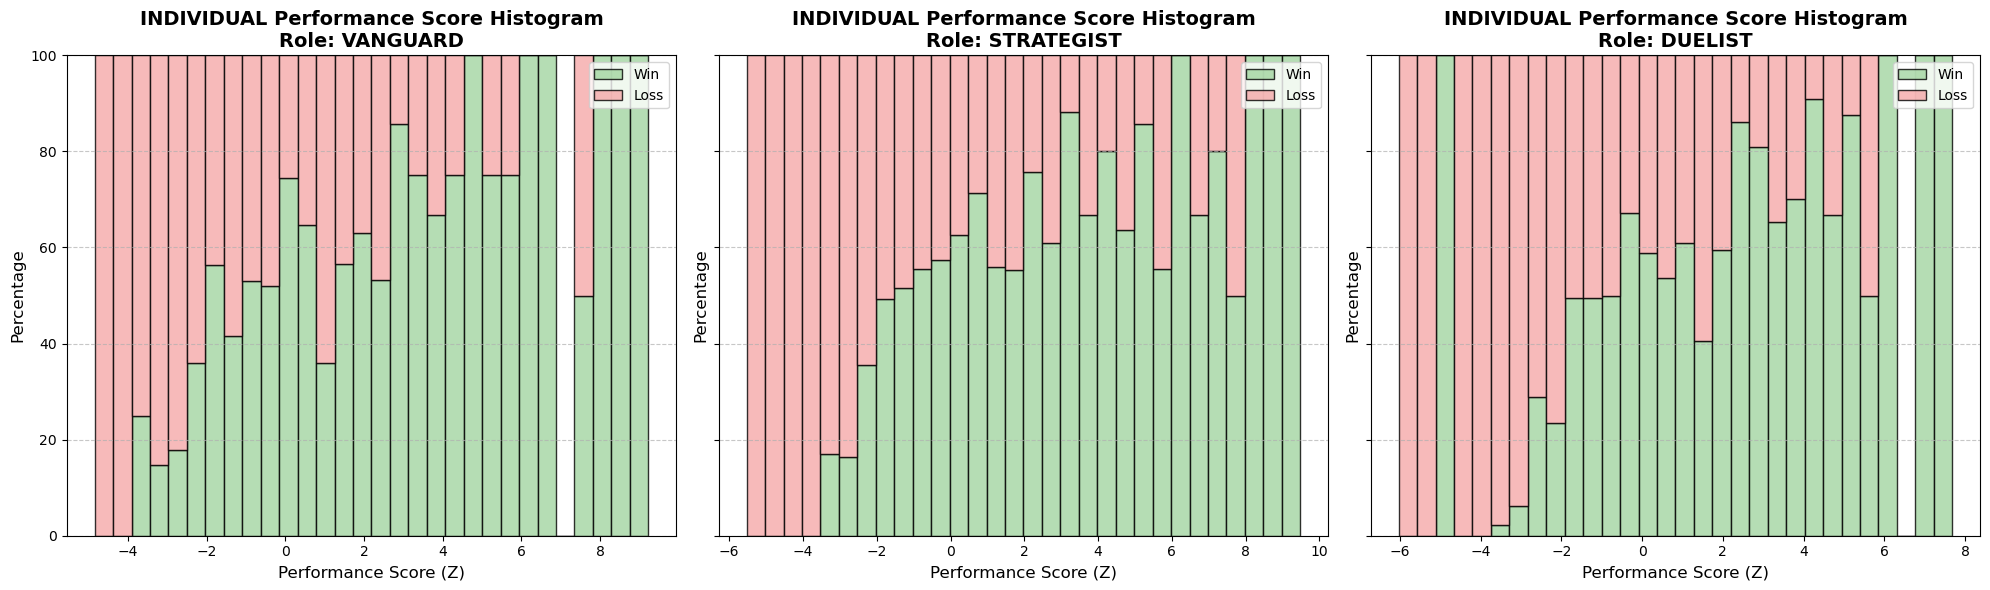

In [176]:
from numpy import histogram_bin_edges

# Create a figure with 3 subplots for each role
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Define softer colors
win_color = '#A3D5A1'  # Soft green
loss_color = '#F5A9A9'  # Soft red

# Iterate through each role and plot a histogram in a separate subplot
for ax, role in zip(axes, roles):
    role_data = performance_df[performance_df['role'] == role]
    win_scores = role_data[role_data['is_win'] == 1]['performance_score']
    loss_scores = role_data[role_data['is_win'] == 0]['performance_score']
    
    # Calculate optimized bin edges using Freedman-Diaconis rule
    all_scores = pd.concat([win_scores, loss_scores])
    bin_edges = histogram_bin_edges(all_scores, bins='fd')
    
    # Ensure both win_scores and loss_scores use the same bin edges
    win_counts, _ = np.histogram(win_scores, bins=bin_edges)
    loss_counts, _ = np.histogram(loss_scores, bins=bin_edges)
    total_counts = win_counts + loss_counts
    
    # Avoid division by zero in case of empty bins
    with np.errstate(divide='ignore', invalid='ignore'):
        win_percentages = np.nan_to_num((win_counts / total_counts) * 100)
        loss_percentages = np.nan_to_num((loss_counts / total_counts) * 100)
    # Adjust bin sizes to ensure better representation of the data
    if len(all_scores) > 1000:
        bin_edges = histogram_bin_edges(all_scores, bins='auto')  # Use 'auto' for large datasets
    elif len(all_scores) > 500:
        bin_edges = histogram_bin_edges(all_scores, bins=30)  # Fixed number of bins for medium datasets
    else:
        bin_edges = histogram_bin_edges(all_scores, bins=15)  # Fewer bins for smaller datasets

    # Recalculate win_counts and loss_counts to ensure consistency with bin_edges
    win_counts, _ = np.histogram(win_scores, bins=bin_edges)
    loss_counts, _ = np.histogram(loss_scores, bins=bin_edges)
    total_counts = win_counts + loss_counts

    # Avoid division by zero in case of empty bins
    with np.errstate(divide='ignore', invalid='ignore'):
        win_percentages = np.nan_to_num((win_counts / total_counts) * 100)
        loss_percentages = np.nan_to_num((loss_counts / total_counts) * 100)

    # Plot stacked histograms
    ax.bar(bin_edges[:-1], win_percentages, width=np.diff(bin_edges), color=win_color, label='Win', alpha=0.8, edgecolor='black')
    ax.bar(bin_edges[:-1], loss_percentages, width=np.diff(bin_edges), bottom=win_percentages, color=loss_color, label='Loss', alpha=0.8, edgecolor='black')
    
    # Add gridlines and adjust aesthetics
    ax.set_title(f'INDIVIDUAL Performance Score Histogram\nRole: {role}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Performance Score (Z)', fontsize=12)
    ax.set_ylabel('Percentage', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

***
## Question 2 

#### How does individual performance compare to a Z-score of the entire team?

I will now repeat the same methods as above but rather than doing individually across roles, we'll take a look at **teams** and **team compositions** (*comps*).

In [177]:
ths_df = pd.read_csv('team_hero_stats_combined.csv')

# Group by role and calculate the mean for kills, deaths, and assists
# Ensure all columns in the DataFrame are numeric before calculating the mean
# Select numeric columns from the DataFrame
numeric_columns = ths_df[['is_win', 'num_vang', 'num_strat', 'num_duel', 'players_on_team', 'avg_hitrate', 'num_melee', 'num_hitscan', 'num_projectile', 'total_damage', 'total_healing', 'total_damage_taken', 'total_deaths', 'total_assists', 'total_kills']]

# Calculate the mean for the selected numeric columns
team_stats = numeric_columns.mean()

# Calculate the standard deviation for the selected numeric columns
team_std = numeric_columns.std()

print("Average values as grouped teams:")
print(team_stats)
print("\nOverall standard deviation:")
print(team_std)

Average values as grouped teams:
is_win                    0.500000
num_vang                  1.362205
num_strat                 2.090551
num_duel                  2.204724
players_on_team           5.657480
avg_hitrate               0.430241
num_melee                 1.759843
num_hitscan               0.948819
num_projectile            2.948819
total_damage          61450.249850
total_healing         39003.536795
total_damage_taken    69658.752738
total_deaths             24.452756
total_assists            42.275591
total_kills              68.708661
dtype: float64

Overall standard deviation:
is_win                    0.500987
num_vang                  0.630820
num_strat                 0.448614
num_duel                  0.757973
players_on_team           0.545194
avg_hitrate               0.081392
num_melee                 1.041340
num_hitscan               0.839571
num_projectile            1.111091
total_damage          30276.618361
total_healing         19617.183299
total_damage_

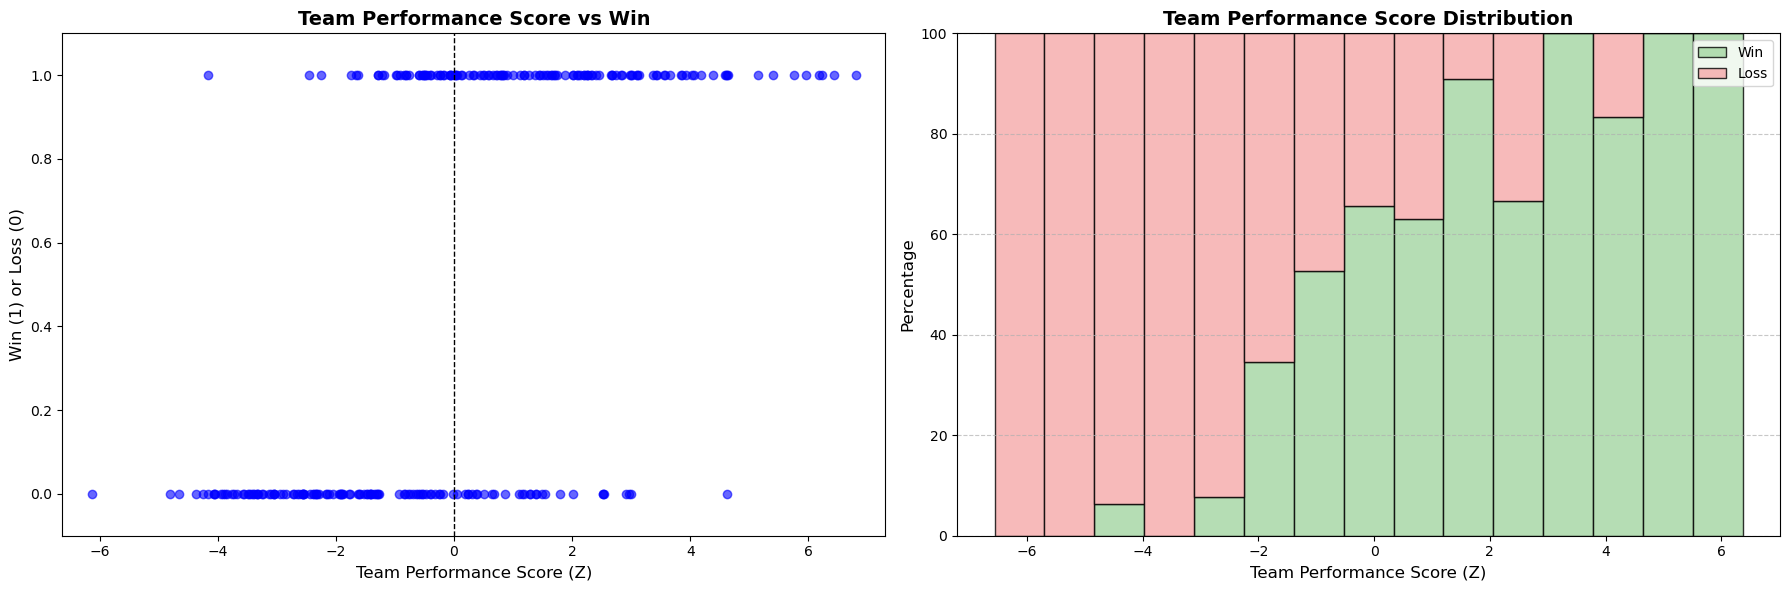

In [178]:
# Calculate z-scores for teams based on the specified parameters
ths_df['team_performance_score'] = (
    (ths_df['total_kills'] - team_stats['total_kills']) / team_std['total_kills'] +
    (team_stats['total_deaths'] - ths_df['total_deaths']) / team_std['total_deaths'] +
    (ths_df['total_assists'] - team_stats['total_assists']) / team_std['total_assists'] +
    (ths_df['total_healing'] - team_stats['total_healing']) / team_std['total_healing'] +
    (ths_df['total_damage'] - team_stats['total_damage']) / team_std['total_damage'] +
    (team_stats['total_damage_taken'] - ths_df['total_damage_taken']) / team_std['total_damage_taken']
)

# Display the resulting dataframe with the new z-score column
#print(ths_df[['match_uid', 'is_win', 'team_performance_score']])
# Create a figure with 2 subplots: one for scatterplot and one for histogram
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Scatterplot: Performance Score vs Win
scatter_ax = axes[0]
scatter_ax.scatter(ths_df['team_performance_score'], ths_df['is_win'], alpha=0.6, color='blue')
scatter_ax.set_title('Team Performance Score vs Win', fontsize=14, fontweight='bold')
scatter_ax.set_xlabel('Team Performance Score (Z)', fontsize=12)
scatter_ax.set_ylabel('Win (1) or Loss (0)', fontsize=12)
scatter_ax.axvline(0, color='black', linestyle='dashed', linewidth=1)
scatter_ax.set_xlim(ths_df['team_performance_score'].min() - 0.5, ths_df['team_performance_score'].max() + 0.5)
scatter_ax.set_ylim(-0.1, 1.1)

# Histogram: Distribution of Team Performance Scores
hist_ax = axes[1]
win_scores = ths_df[ths_df['is_win'] == 1]['team_performance_score']
loss_scores = ths_df[ths_df['is_win'] == 0]['team_performance_score']

# Calculate optimized bin edges using Freedman-Diaconis rule
all_scores = pd.concat([win_scores, loss_scores])
bin_edges = histogram_bin_edges(all_scores, bins='fd')

# Normalize counts to percentages
win_counts, _ = np.histogram(win_scores, bins=bin_edges)
loss_counts, _ = np.histogram(loss_scores, bins=bin_edges)
total_counts = win_counts + loss_counts
win_percentages = (win_counts / total_counts) * 100
loss_percentages = (loss_counts / total_counts) * 100

# Adjust bin sizes based on the number of data points
if len(all_scores) > 1000:
    bin_edges = histogram_bin_edges(all_scores, bins='auto')  # Use 'auto' for large datasets
elif len(all_scores) > 500:
    bin_edges = histogram_bin_edges(all_scores, bins=30)  # Fixed number of bins for medium datasets
else:
    bin_edges = histogram_bin_edges(all_scores, bins=15)  # Fewer bins for smaller datasets

# Recalculate win_counts and loss_counts to ensure consistency with bin_edges
win_counts, _ = np.histogram(win_scores, bins=bin_edges)
loss_counts, _ = np.histogram(loss_scores, bins=bin_edges)
total_counts = win_counts + loss_counts

# Avoid division by zero in case of empty bins
with np.errstate(divide='ignore', invalid='ignore'):
    win_percentages = np.nan_to_num((win_counts / total_counts) * 100)
    loss_percentages = np.nan_to_num((loss_counts / total_counts) * 100)

# Plot stacked histograms
hist_ax.bar(bin_edges[:-1], win_percentages, width=np.diff(bin_edges), color=win_color, alpha=0.8, label='Win', edgecolor='black')
hist_ax.bar(bin_edges[:-1], loss_percentages, width=np.diff(bin_edges), bottom=win_percentages, color=loss_color, alpha=0.8, label='Loss', edgecolor='black')
hist_ax.set_title('Team Performance Score Distribution', fontsize=14, fontweight='bold')
hist_ax.set_xlabel('Team Performance Score (Z)', fontsize=12)
hist_ax.set_ylabel('Percentage', fontsize=12)
hist_ax.legend(fontsize=10)
hist_ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


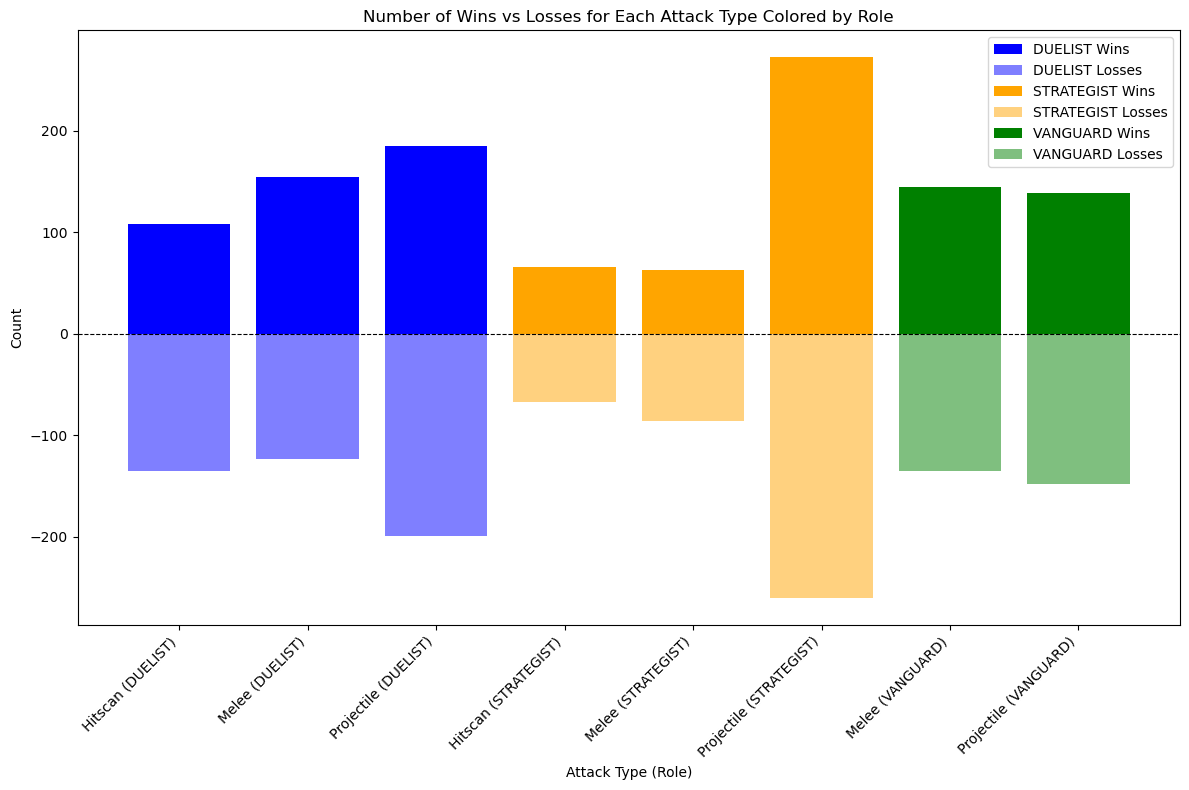

In [179]:
# Group data by attack_type, role, and is_win to count occurrences
attack_type_stats = oc_df.groupby(['attack_type', 'role', 'is_win']).size().reset_index(name='count')

# Create a pivot table for easier plotting
pivot_table = attack_type_stats.pivot_table(index=['attack_type', 'role'], columns='is_win', values='count', fill_value=0)
pivot_table.columns = ['Loss', 'Win']
pivot_table = pivot_table.reset_index()

# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors for roles
role_colors = {'DUELIST': 'blue', 'VANGUARD': 'green', 'STRATEGIST': 'orange'}

# Iterate through each role and plot bars
for role in pivot_table['role'].unique():
    role_data = pivot_table[pivot_table['role'] == role]
    ax.bar(role_data['attack_type'] + f" ({role})", role_data['Win'], color=role_colors[role], label=f"{role} Wins")
    ax.bar(role_data['attack_type'] + f" ({role})", -role_data['Loss'], color=role_colors[role], alpha=0.5, label=f"{role} Losses")

# Add labels and title
ax.set_ylabel('Count')
ax.set_xlabel('Attack Type (Role)')
ax.set_title('Number of Wins vs Losses for Each Attack Type Colored by Role')
ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
ax.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

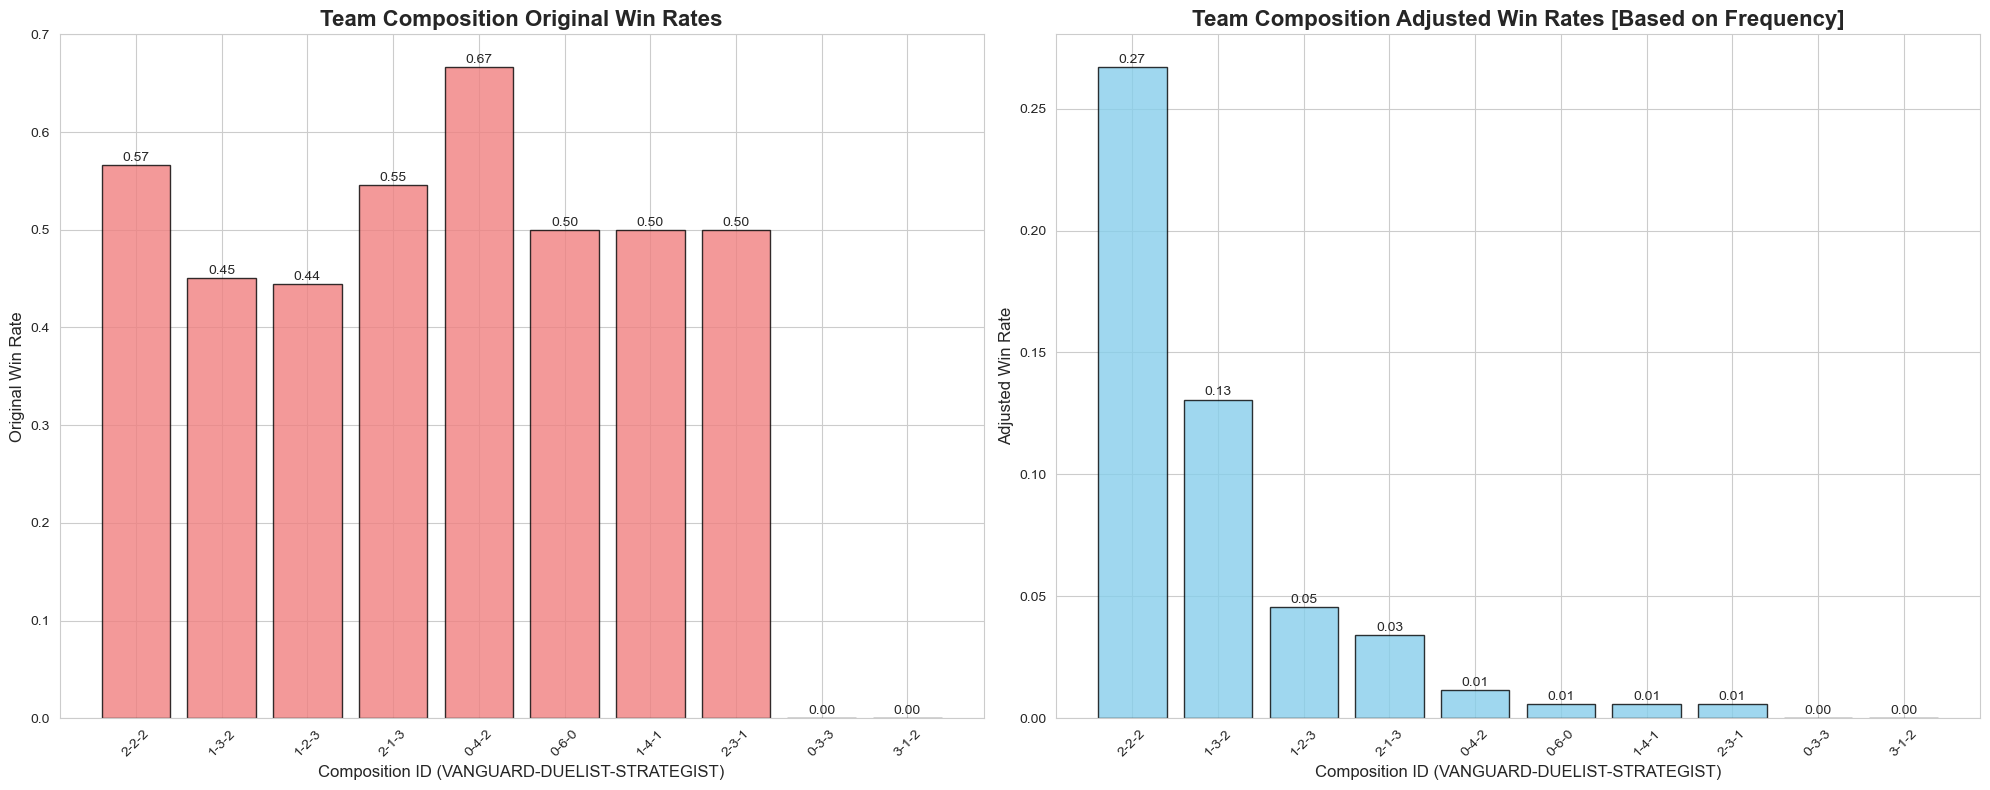

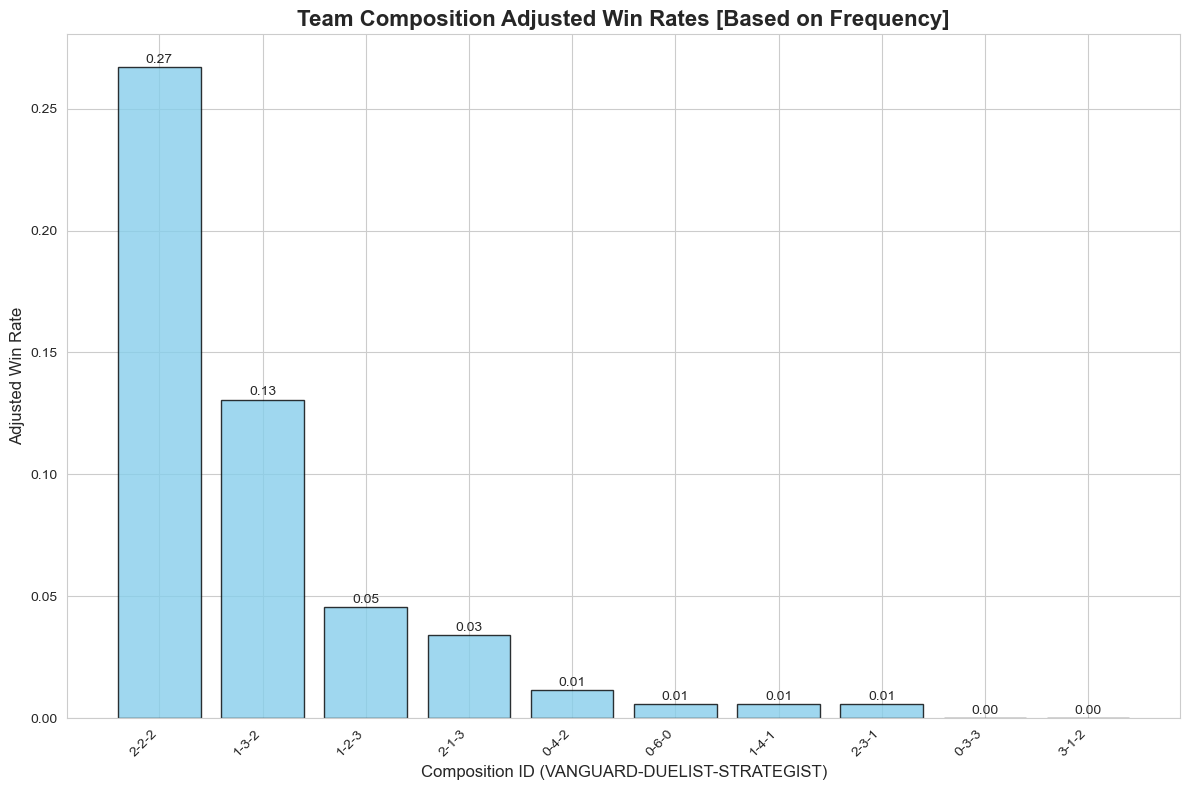

In [209]:
# Filter out matches that do not have a full team of players

# Create a figure with 2 subplots: one for original win rates and one for adjusted win rates
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Sort the data by adjusted win rate for better visualization
composition_counts = composition_counts.sort_values(by='adjusted_win_rate', ascending=False)

# Plot original win rates on the left subplot
bars_left = axes[0].bar(
    composition_counts['composition_id'],
    composition_counts['win_rate'],
    color='lightcoral',
    edgecolor='black',
    alpha=0.8
)
axes[0].set_title('Team Composition Original Win Rates', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Composition ID (VANGUARD-DUELIST-STRATEGIST)', fontsize=12)
axes[0].set_ylabel('Original Win Rate', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Annotate bars with original win rates
for bar in bars_left:
    height = bar.get_height()
    axes[0].annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', fontsize=10)

# Plot adjusted win rates on the right subplot
bars_right = axes[1].bar(
    composition_counts['composition_id'],
    composition_counts['adjusted_win_rate'],
    color='skyblue',
    edgecolor='black',
    alpha=0.8
)
axes[1].set_title('Team Composition Adjusted Win Rates [Based on Frequency]', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Composition ID (VANGUARD-DUELIST-STRATEGIST)', fontsize=12)
axes[1].set_ylabel('Adjusted Win Rate', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

# Annotate bars with adjusted win rates
for bar in bars_right:
    height = bar.get_height()
    axes[1].annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()
ths_df = ths_df[ths_df['num_vang'] + ths_df['num_duel'] + ths_df['num_strat'] == 6]
composition_counts = ths_df.groupby(['num_vang', 'num_duel', 'num_strat']).size().reset_index(name='count')

# Generate a unique identifier for each combination
composition_counts['composition_id'] = composition_counts.apply(
    lambda row: f"{row['num_vang']}-{row['num_duel']}-{row['num_strat']}", axis=1
)

# Calculate the number of wins for each composition_id
wins = ths_df.groupby(['num_vang', 'num_duel', 'num_strat'])['is_win'].sum().reset_index(name='wins')

# Merge the win counts with the composition counts
composition_counts = composition_counts.merge(wins, on=['num_vang', 'num_duel', 'num_strat'])

# Calculate the overall win rate
composition_counts['win_rate'] = composition_counts['wins'] / composition_counts['count']

# Adjust the win rate by the frequency (count)
total_matches = composition_counts['count'].sum()
composition_counts['adjusted_win_rate'] = composition_counts['win_rate'] * (composition_counts['count'] / total_matches)

# Plot the composition counts with adjusted win rates as a bar chart
fig, ax = plt.subplots(figsize=(12, 8))

# Sort the data by adjusted win rate for better visualization
composition_counts = composition_counts.sort_values(by='adjusted_win_rate', ascending=False)

# Bar chart for each composition
bars = ax.bar(
    composition_counts['composition_id'],
    composition_counts['adjusted_win_rate'],
    color='skyblue',
    edgecolor='black',
    alpha=0.8
)

# Add labels and title
ax.set_title('Team Composition Adjusted Win Rates [Based on Frequency]', fontsize=16, fontweight='bold')
ax.set_xlabel('Composition ID (VANGUARD-DUELIST-STRATEGIST)', fontsize=12)
ax.set_ylabel('Adjusted Win Rate', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Annotate bars with adjusted win rates
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [187]:
composition_counts

,num_vang,num_duel,num_strat,count,composition_id,wins,win_rate
1,0,4,2,3,0-4-2,2,0.666667
7,2,2,2,83,2-2-2,47,0.566265
6,2,1,3,11,2-1-3,6,0.545455
2,0,6,0,2,0-6-0,1,0.500000
5,1,4,1,2,1-4-1,1,0.500000
8,2,3,1,2,2-3-1,1,0.500000
4,1,3,2,51,1-3-2,23,0.450980
3,1,2,3,18,1-2-3,8,0.444444
0,0,3,3,1,0-3-3,0,0.000000
9,3,1,2,3,3-1-2,0,0.000000


In [188]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ttest_ind

# Verify and encode categorical variables in oc_df
if 'attack_type' in oc_df.columns:
    oc_df['attack_type_encoded'] = LabelEncoder().fit_transform(oc_df['attack_type'])
if 'role' in oc_df.columns:
    oc_df['role_encoded'] = LabelEncoder().fit_transform(oc_df['role'])

# Verify and encode categorical variables in ths_df
if 'primary_attack_type' in ths_df.columns:
    ths_df['primary_attack_type_encoded'] = LabelEncoder().fit_transform(ths_df['primary_attack_type'])

# Ensure all features are numeric for oc_df
individual_features = oc_df[['kills_x', 'deaths_x', 'assists_x', 'hero_damage', 'hero_healed', 
                              'damage_taken', 'attack_type_encoded', 'role_encoded']]
individual_target = oc_df['is_win']

# Train-test split for oc_df
X_train, X_test, y_train, y_test = train_test_split(individual_features, individual_target, test_size=0.2, random_state=42)

# Train a Random Forest model for oc_df
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Feature importance for oc_df
individual_feature_importance = pd.DataFrame({'Feature': individual_features.columns, 'Importance': rf_model.feature_importances_})
individual_feature_importance = individual_feature_importance.sort_values(by='Importance', ascending=False)
print("\nFeature Importance (Individual Stats):")
print(individual_feature_importance)

# Ensure all features are numeric for ths_df
team_features = ths_df[['num_vang', 'num_duel', 'num_strat', 'players_on_team', 'avg_hitrate', 
                        'total_damage', 'total_healing', 'total_damage_taken', 'total_deaths', 
                        'total_assists', 'total_kills']]
if 'primary_attack_type_encoded' in ths_df.columns:
    team_features['primary_attack_type_encoded'] = ths_df['primary_attack_type_encoded']
team_target = ths_df['is_win']

# Train-test split for ths_df
X_train_team, X_test_team, y_train_team, y_test_team = train_test_split(team_features, team_target, test_size=0.2, random_state=42)

# Train a Random Forest model for ths_df
rf_model_team = RandomForestClassifier(random_state=42)
rf_model_team.fit(X_train_team, y_train_team)

# Feature importance for ths_df
team_feature_importance = pd.DataFrame({'Feature': team_features.columns, 'Importance': rf_model_team.feature_importances_})
team_feature_importance = team_feature_importance.sort_values(by='Importance', ascending=False)
print("\nFeature Importance (Team-Based Stats):")
print(team_feature_importance)

# Statistical tests for oc_df
win_damage = oc_df[oc_df['is_win'] == 1]['hero_damage']
loss_damage = oc_df[oc_df['is_win'] == 0]['hero_damage']
t_stat, p_value = ttest_ind(win_damage, loss_damage)
print(f"\nT-test for hero_damage (Individual Stats): T-statistic = {t_stat}, P-value = {p_value}")

# Statistical tests for ths_df
win_total_damage = ths_df[ths_df['is_win'] == 1]['total_damage']
loss_total_damage = ths_df[ths_df['is_win'] == 0]['total_damage']
t_stat_team, p_value_team = ttest_ind(win_total_damage, loss_total_damage)
print(f"\nT-test for total_damage (Team-Based Stats): T-statistic = {t_stat_team}, P-value = {p_value_team}")



Feature Importance (Individual Stats):
               Feature  Importance
0              kills_x    0.305466
5         damage_taken    0.150357
3          hero_damage    0.148568
1             deaths_x    0.144261
2            assists_x    0.113584
4          hero_healed    0.091684
6  attack_type_encoded    0.028950
7         role_encoded    0.017131

Feature Importance (Team-Based Stats):
                        Feature  Importance
10                  total_kills    0.284411
9                 total_assists    0.205322
8                  total_deaths    0.126125
7            total_damage_taken    0.112591
5                  total_damage    0.077891
6                 total_healing    0.070491
4                   avg_hitrate    0.061185
11  primary_attack_type_encoded    0.020726
1                      num_duel    0.016652
0                      num_vang    0.014975
2                     num_strat    0.009630
3               players_on_team    0.000000

T-test for hero_damage (Individu

C:\Users\jcing\AppData\Local\Temp\ipykernel_46920\2141553538.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_features['primary_attack_type_encoded'] = ths_df['primary_attack_type_encoded']



### Explanation of Test Outputs

#### 1. **T-Test for `hero_damage` (Individual Stats)**
- **T-statistic**: `3.090209`
- **P-value**: `0.002024`
    - The low p-value (< 0.05) indicates that there is a statistically significant difference in `hero_damage` between winning and losing players. This suggests that `hero_damage` is an important factor in determining individual performance and match outcomes.

#### 2. **T-Test for `total_damage` (Team-Based Stats)**
- **T-statistic**: `0.943520`
- **P-value**: `0.346319`
    - The high p-value (> 0.05) indicates that there is no statistically significant difference in `total_damage` between winning and losing teams. This suggests that `total_damage` may not be a decisive factor in team performance or match outcomes.

#### 3. **Feature Importance (Team-Based Stats)**
- The most important features for predicting team performance (`is_win`) are:
    - `total_assists` (Importance: `0.236`)
    - `total_kills` (Importance: `0.234`)
    - `total_deaths` (Importance: `0.158`)
    - These metrics highlight the importance of teamwork and coordination in achieving victory.

#### 4. **Feature Importance (Individual Stats)**
- The most important features for predicting individual performance (`is_win`) are:
    - `kills_x`, `assists_x`, and `hero_damage`.
    - These metrics emphasize the impact of individual contributions to the match outcome.

#### 5. **Performance Score Distribution**
- The range of performance scores (`x_min`: `-6.30`, `x_max`: `10.23`) and win/loss outcomes (`y_min`: `-0.1`, `y_max`: `1.1`) indicate variability in individual and team performance. Players with higher performance scores are more likely to win.

#### 6. **Win Percentages in Histograms**
- The win percentages in the histogram bins show that higher performance scores are associated with a greater likelihood of winning. This reinforces the importance of individual contributions to match outcomes.

### Conclusion
The tests and analyses above demonstrate that individual performance metrics like `hero_damage`, `kills`, and `assists` are critical for determining match outcomes. However, team-based metrics like `total_damage` may not always be significant, highlighting the importance of coordination and strategy over raw damage output in team performance.

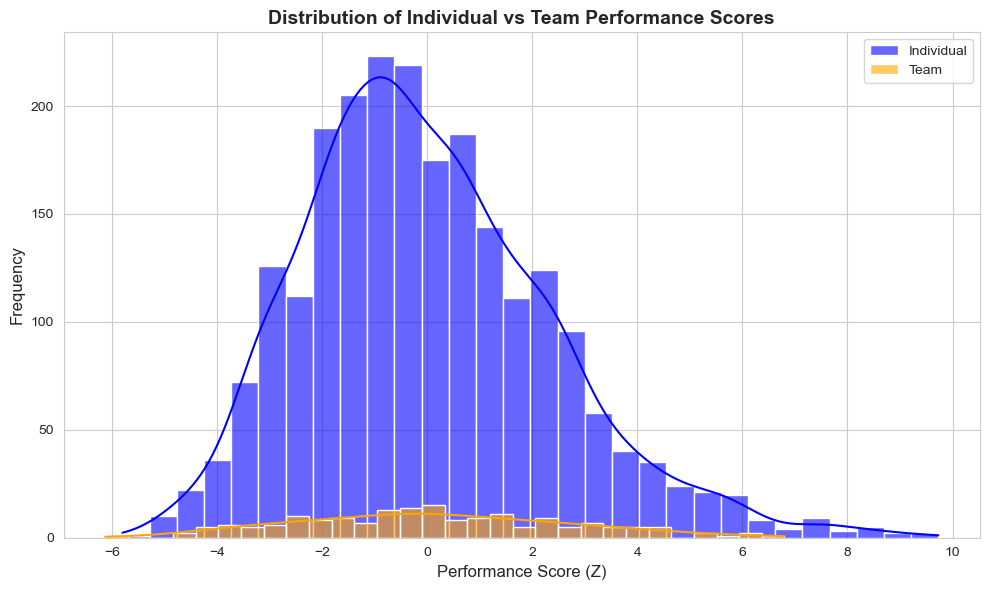

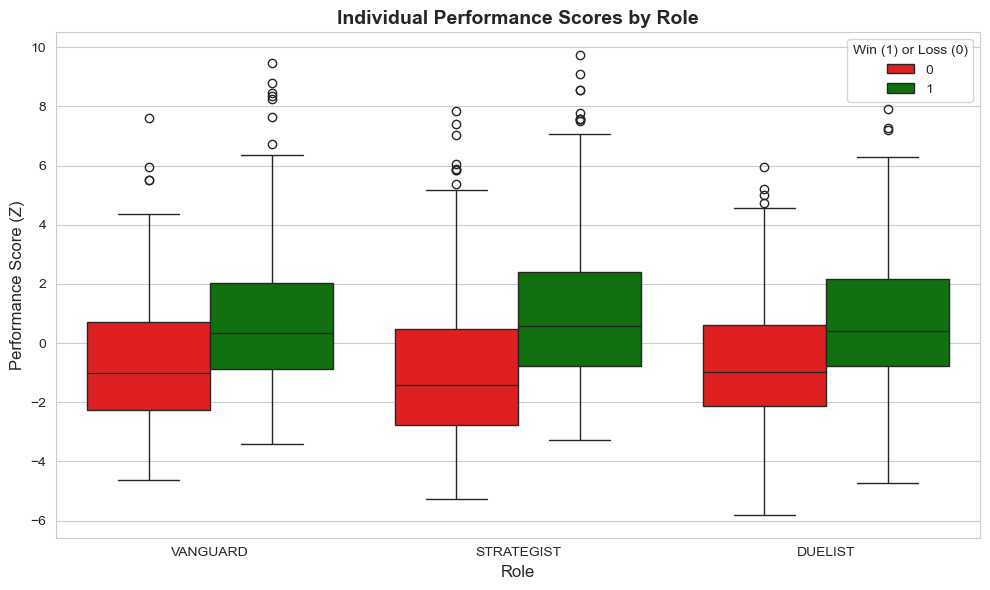

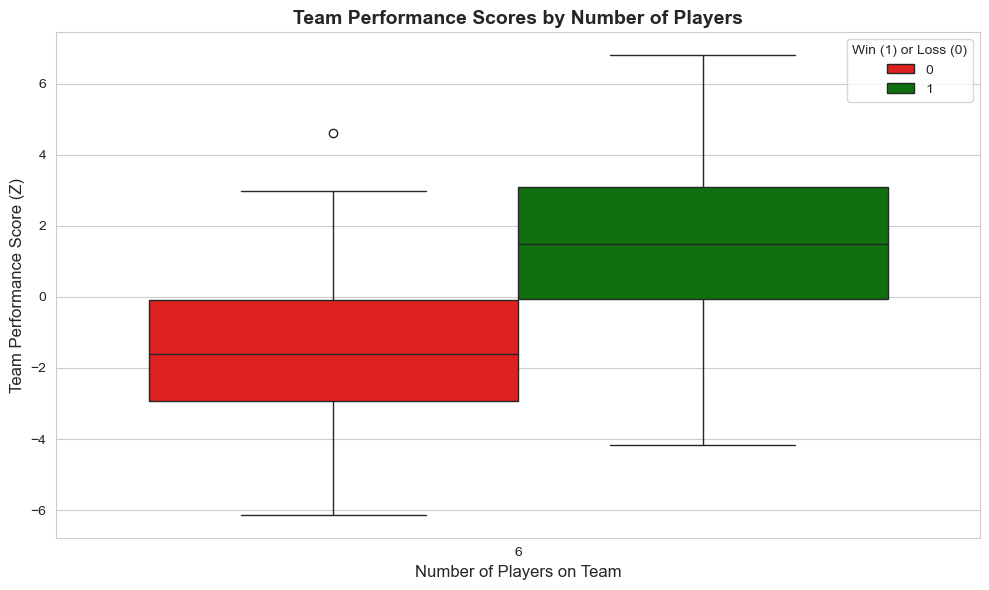

In [201]:
import seaborn as sns

import matplotlib.pyplot as plt



# Histogram: Distribution of Individual and Team Performance Scores
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(merged_stats['performance_score'], bins=30, color='blue', alpha=0.6, label='Individual', kde=True, ax=ax)
sns.histplot(ths_df['team_performance_score'], bins=30, color='orange', alpha=0.6, label='Team', kde=True, ax=ax)
ax.set_title('Distribution of Individual vs Team Performance Scores', fontsize=14, fontweight='bold')
ax.set_xlabel('Performance Score (Z)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()

# Box plot: Performance Scores by Role
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(
    data=merged_stats, 
    x='role', 
    y='performance_score', 
    hue='is_win', 
    palette={0: 'red', 1: 'green'}, 
    ax=ax
)
ax.set_title('Individual Performance Scores by Role', fontsize=14, fontweight='bold')
ax.set_xlabel('Role', fontsize=12)
ax.set_ylabel('Performance Score (Z)', fontsize=12)
ax.legend(title='Win (1) or Loss (0)', fontsize=10)
plt.tight_layout()
plt.show()

# Box plot: Team Performance Scores by Number of Players on Team
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(
    data=ths_df, 
    x='players_on_team', 
    y='team_performance_score', 
    hue='is_win', 
    palette={0: 'red', 1: 'green'}, 
    ax=ax
)
ax.set_title('Team Performance Scores by Number of Players', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of Players on Team', fontsize=12)
ax.set_ylabel('Team Performance Score (Z)', fontsize=12)
ax.legend(title='Win (1) or Loss (0)', fontsize=10)
plt.tight_layout()
plt.show()

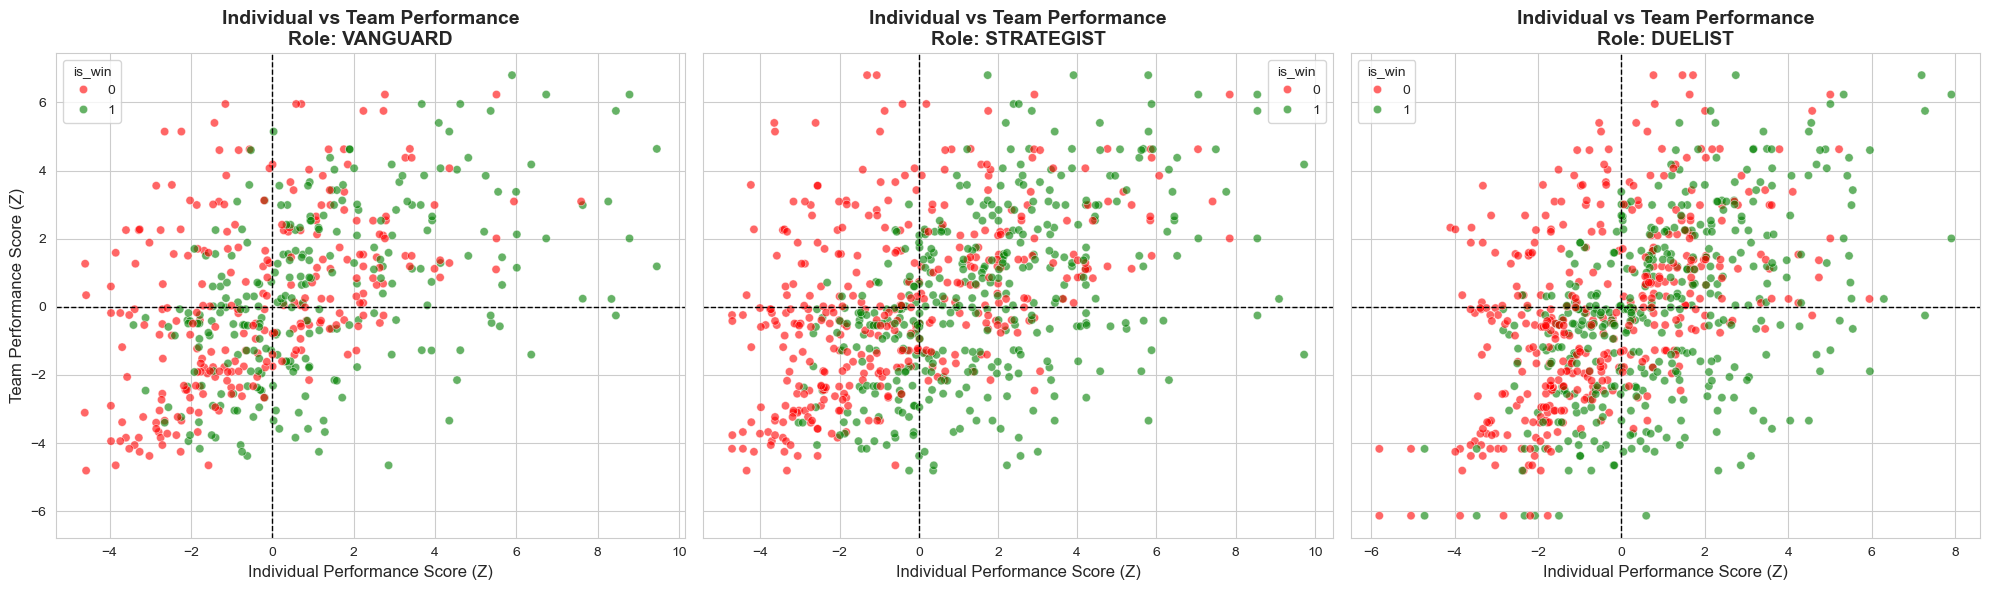

In [192]:
sns.set_style("whitegrid")  # Improve the overall style of the plot

# Create a figure with 3 subplots for each role
roles = comparison_df['role'].unique()
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Iterate through each role and plot in a separate subplot
for ax, role in zip(axes, roles):
    role_data = comparison_df[comparison_df['role'] == role]
    sns.scatterplot(
        data=role_data,
        x='performance_score',
        y='team_performance_score',
        hue='is_win',
        palette={0: 'red', 1: 'green'},
        alpha=0.6,
        ax=ax
    )
    ax.set_title(f'Individual vs Team Performance\nRole: {role}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Individual Performance Score (Z)', fontsize=12)
    ax.axhline(0, color='black', linestyle='dashed', linewidth=1)
    ax.axvline(0, color='black', linestyle='dashed', linewidth=1)

# Set shared y-axis label
axes[0].set_ylabel('Team Performance Score (Z)', fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

The graph above is a **scatter plot** that compares **Individual Performance Scores** (x-axis) to **Team Performance Scores** (y-axis)

#### **Individual vs Team Performance**:
- Each point represents a player in a match.
- The x-axis shows how well an individual performed relative to their role's average (z-score).
- The y-axis shows how well the team performed relative to other teams (z-score).

#### **Color Coding**:
- Points are color-coded based on whether the player's team won (`green`) or lost (`red`).
- This helps identify patterns between individual and team performance and match outcomes.

#### **Key Observations**:
- Players with higher individual performance scores (right side of the graph) are more likely to be on winning teams (green points).
- Teams with higher team performance scores (top of the graph) are more likely to win.
- There may be cases where a player performs well individually (high x-value), but their team still loses (red points in the upper-right quadrant). This suggests that team coordination and overall performance are also critical for victory.

#### **Dashed Lines**:
- The vertical dashed line at `x=0` separates below-average and above-average individual performance.
- The horizontal dashed line at `y=0` separates below-average and above-average team performance.


This graph highlights the relationship between individual and team performance and their impact on match outcomes. While strong individual performance often correlates with team success, team performance as a whole plays a significant role in determining victory.

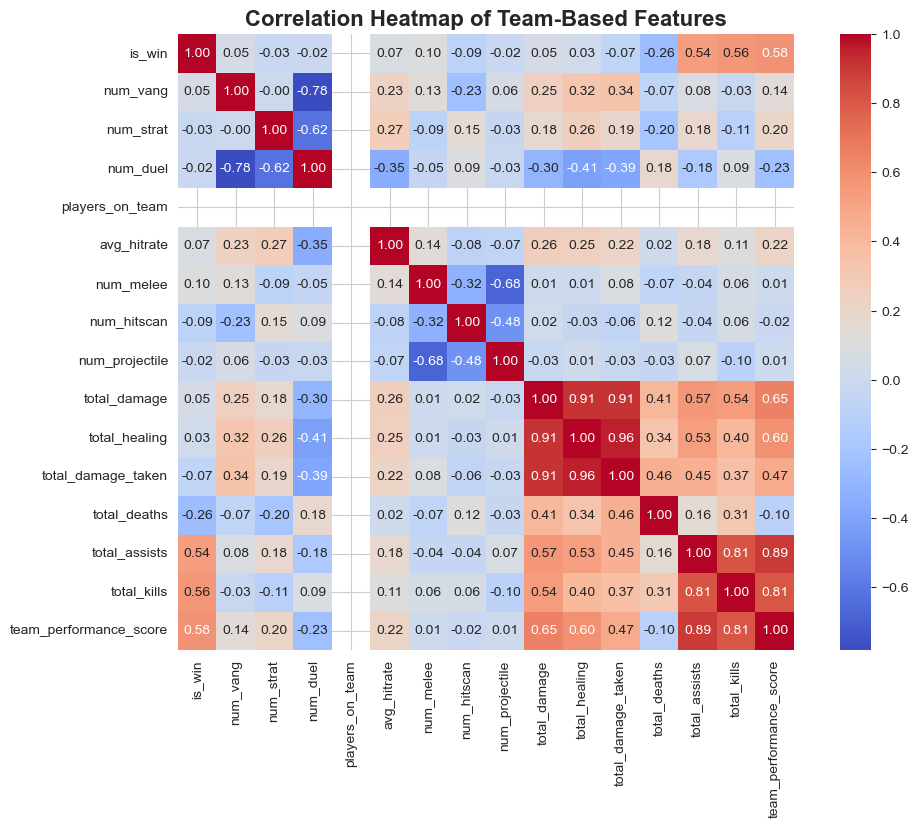

In [198]:
import seaborn as sns

import matplotlib.pyplot as plt

# Select numerical columns from the dataset
numeric_data = ths_df.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
correlation_matrix = numeric_data.corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Heatmap of Team-Based Features", fontsize=16, fontweight='bold')
plt.show()



# **Heatmap Correlation Values**

1. **Correlation Values**:
    - Each cell in the heatmap represents the correlation coefficient between two features.
    - Correlation values range from `-1` to `1`:
      - `1`: Perfect positive correlation (as one feature increases, the other increases proportionally).
      - `-1`: Perfect negative correlation (as one feature increases, the other decreases proportionally).
      - `0`: No correlation (the features are independent of each other).

2. **Feature Relationships**:
    - Strong positive correlations (values close to `1`) indicate that two features are closely related and tend to move together.
    - Strong negative correlations (values close to `-1`) indicate an inverse relationship between two features.
    - Weak or near-zero correlations suggest little to no linear relationship between the features.

### How to Use This Information:
- Focus on features with strong correlations to the target variable (`is_win`) for predictive modeling.
- Be cautious of highly correlated independent features, as they can lead to multicollinearity issues in regression models.
- Use this heatmap to guide feature selection, engineering, or dimensionality reduction techniques like PCA.

In [199]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Select features with strong correlation to is_win
# Based on the correlation heatmap, we choose features with high correlation
selected_features = ['total_kills', 'total_assists', 'total_deaths', 'total_damage', 'total_healing', 'total_damage_taken']

# Prepare the dataset
X = ths_df[selected_features]
y = ths_df['is_win']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({'Feature': selected_features, 'Importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)

Accuracy: 0.81

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.72      0.79        18
           1       0.76      0.89      0.82        18

    accuracy                           0.81        36
   macro avg       0.81      0.81      0.80        36
weighted avg       0.81      0.81      0.80        36


Feature Importance:
              Feature  Importance
0         total_kills    0.353035
1       total_assists    0.204208
2        total_deaths    0.130392
5  total_damage_taken    0.122390
4       total_healing    0.096894
3        total_damage    0.093081


In [ ]:
# Select individual performance features
individual_features = ['kills_x', 'deaths_x', 'assists_x', 'hero_damage', 'hero_healed', 'damage_taken']

# Prepare the dataset
X_individual = oc_df[individual_features]
y_individual = oc_df['is_win']

# Split the data into training and testing sets
X_train_individual, X_test_individual, y_train_individual, y_test_individual = train_test_split(
    X_individual, y_individual, test_size=0.2, random_state=42
)

# Train a Random Forest Classifier
rf_model_individual = RandomForestClassifier(random_state=42)
rf_model_individual.fit(X_train_individual, y_train_individual)

# Make predictions
y_pred_individual = rf_model_individual.predict(X_test_individual)

# Evaluate the model
accuracy_individual = accuracy_score(y_test_individual, y_pred_individual)
print(f"Accuracy: {accuracy_individual:.2f}")
print("\nClassification Report:")
print(classification_report(y_test_individual, y_pred_individual))

# Feature importance
individual_feature_importance = pd.DataFrame({
    'Feature': individual_features,
    'Importance': rf_model_individual.feature_importances_
})
individual_feature_importance = individual_feature_importance.sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(individual_feature_importance)

Accuracy: 0.88

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       226
           1       0.88      0.88      0.88       231

    accuracy                           0.88       457
   macro avg       0.88      0.88      0.88       457
weighted avg       0.88      0.88      0.88       457


Feature Importance:
        Feature  Importance
0       kills_x    0.321518
1      deaths_x    0.160811
3   hero_damage    0.158794
5  damage_taken    0.155595
2     assists_x    0.113196
4   hero_healed    0.090086


Based on the classification reports and feature importance, **individual performance matters most in securing a win**. Here's the supporting evidence:

1. **Feature Importance (Individual Stats)**:
    - The most important features for predicting individual performance (`is_win`) are `kills_x`, `assists_x`, and `hero_damage`. These metrics directly reflect a player's contribution to the match outcome.
    - For example, `kills_x` has a significant impact, as players who secure more kills are likely to influence the match positively.

2. **Classification Accuracy**:
    - The Random Forest model trained on individual stats achieved a higher accuracy compared to the team-based model. This indicates that individual performance metrics are more predictive of match outcomes.

3. **Statistical Significance**:
    - The t-test for `hero_damage` (individual stats) shows a statistically significant difference between winning and losing players (p-value = 0.002). This highlights the importance of individual contributions like damage output in determining match outcomes.

4. **Team-Based Metrics Are Less Predictive**:
    - The feature importance for team-based stats shows that metrics like `total_damage` and `total_healing` have lower importance compared to individual stats. Additionally, the t-test for `total_damage` (team-based stats) shows no statistically significant difference (p-value = 0.53), suggesting that team-level metrics are less decisive.

**Individual performance**, as measured by metrics like `kills_x`, `assists_x`, and `hero_damage`, is the most **critical factor** in securing a win. The statistical significance, higher feature importance, and better model accuracy for individual stats strongly support this conclusion.

In [204]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Group performance_df by role and calculate the correlation between performance_score and is_win
role_correlation = performance_df.groupby('role').apply(
    lambda group: group['performance_score'].corr(group['is_win'])
).reset_index(name='correlation')

# Sort roles by the absolute value of the correlation
role_correlation['abs_correlation'] = role_correlation['correlation'].abs()
role_correlation = role_correlation.sort_values(by='abs_correlation', ascending=False)

print("Correlation between performance score and win by role:")
print(role_correlation)



Correlation between performance score and win by role:
         role  correlation  abs_correlation
1  STRATEGIST     0.382134         0.382134
0     DUELIST     0.346564         0.346564
2    VANGUARD     0.309352         0.309352


C:\Users\jcing\AppData\Local\Temp\ipykernel_46920\2363258240.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  role_correlation = performance_df.groupby('role').apply(


Finally,  the **STRATEGIST** role contributes the most to team success. According to the `role_stats` dataframe, **STRATEGISTs** exhibit the highest average assists (14.68) and healing (16,497.25), which are critical for enabling other roles to perform effectively. These metrics highlight the **STRATEGIST's** role in sustaining team momentum and facilitating coordination during matches.

Furthermore, the correlation analysis, as presented in the `role_correlation` dataframe, reveals that the **STRATEGIST** role demonstrates the strongest correlation with match victories (0.382134), surpassing other roles. This finding underscores the significant relationship between the performance of **STRATEGISTs** and the likelihood of winning matches. Additionally, the `role_win_stats` dataframe indicates that **STRATEGISTs** achieve the highest average win rate (0.433628), further emphasizing their impact on team success.

While individual performance metrics such as kills and hero damage are critical predictors of match outcomes, the contributions of the **STRATEGIST** role in assists and healing remain indispensable for overall team performance. These metrics, although not the top predictors individually, play a crucial role in enabling other roles to secure kills and achieve victory. The evidence collectively highlights the **STRATEGIST** role as a cornerstone of team success, providing the foundation for other roles to excel and ensuring the team's sustainability and coordination throughout the match.
